Machine learning models trained on historical data can unintentionally learn and amplify societal biases. In credit decision-making, for instance, a model may favor certain age groups if past data shows higher repayment rates among them — even if using age as a factor is legally or ethically problematic.

AI Fairness 360 (AIF360) is a toolkit that provides fairness metrics to detect such biases, and mitigation techniques to address them. By identifying protected attributes (e.g., age, race, gender), it enables developers to audit and improve the fairness of ML systems, ensuring both ethical integrity and regulatory compliance.

This tutorial demonstrates how to apply AIF360 to detect and mitigate age bias in credit decisions.

In [1]:
import numpy as np
import pandas as pd
np.random.seed(0)

from aif360.datasets import GermanDataset
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing

from IPython.display import Markdown, display

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


## Step 1: Load dataset, specifying protected attribute, and split dataset into train and test
We load the initial dataset, setting the protected attribute to be age.  We then splits the original dataset into training and testing datasets.  Although we will use only  the training dataset in this tutorial, a normal workflow would also use a test dataset for assessing the efficacy (accuracy, fairness, etc.) during the development of a machine learning model.  Finally, we set two variables (to be used in Step 3) for the privileged (1) and unprivileged (0) values for the age attribute.

In [3]:
# copy the data/german_credits/german.data and data/german_credits/german.txt into
# Mac: /opt/anaconda3/envs/ccai9012/lib/python3.13/site-packages/aif360/data/raw/german
# Windows: C:\Users\<USER_NAME>\Anaconda3\envs\ccai9012\Lib\site-packages\aif360\data\raw\german

dataset_orig = GermanDataset(
    protected_attribute_names=['age'],           # this dataset also contains protected
                                                 # attribute for "sex" which we do not
                                                 # consider in this evaluation
    privileged_classes=[lambda x: x >= 25],      # age >=25 is considered privileged
    features_to_drop=['personal_status', 'sex'] # ignore sex-related attributes
)

dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

privileged_groups = [{'age': 1}]
unprivileged_groups = [{'age': 0}]

## Step 2: Compute fairness metric on original training dataset
Now that we've identified the protected attribute 'age' and defined privileged and unprivileged values, we can use aif360 to detect bias in the dataset.  One simple test is to compare the percentage of favorable results for the privileged and unprivileged groups, subtracting the former percentage from the latter.   A negative value indicates less favorable outcomes for the unprivileged groups.  This is implemented in the method called mean_difference on the BinaryLabelDatasetMetric class.

In [4]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.169905


## Step 3: Mitigate bias by transforming the original dataset
The previous step showed that the privileged group was getting 17% more positive outcomes in the training dataset.   Since this is not desirable, we are going to try to mitigate this bias in the training dataset.  As stated above, this is called _pre-processing_ mitigation because it happens before the creation of the model.  

AI Fairness 360 implements several pre-processing mitigation algorithms.  We will choose the Reweighing algorithm [1], which is implemented in the `Reweighing` class in the `aif360.algorithms.preprocessing` package.  This algorithm will transform the dataset to have more equity in positive outcomes on the protected attribute for the privileged and unprivileged groups.

We then call the fit and transform methods to perform the transformation, producing a newly transformed training dataset (dataset_transf_train).

`[1] F. Kamiran and T. Calders,  "Data Preprocessing Techniques for Classification without Discrimination," Knowledge and Information Systems, 2012.`

In [5]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_train = RW.fit_transform(dataset_orig_train)

## Step 4: Compute fairness metric on transformed dataset
Now that we have a transformed dataset, we can check how effective it was in removing bias by using the same metric we used for the original training dataset in Step 3.  Once again, we use the function mean_difference in the BinaryLabelDatasetMetric class.   We see the mitigation step was very effective, the difference in mean outcomes is now 0.0.  So we went from a 17% advantage for the privileged group to equality in terms of mean outcome.

In [6]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                               unprivileged_groups=unprivileged_groups,
                                               privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


## Step 5: How is the data transformed?

The Reweighing algorithm is a preprocessing bias mitigation technique that assigns weights to training samples based on their protected group membership and class label. 

- It calculates the expected distribution of favorable and unfavorable labels across privileged and unprivileged groups.
- Then, it adjusts the weight of each sample to correct imbalances, effectively balancing the joint distribution of `(protected attribute, label)` pairs.
- For example, if an unprivileged group has fewer favorable outcomes, samples from that group with favorable labels will receive higher weights.
- Conversely, samples from privileged groups or more frequent `(group, label)` combinations will have their weights decreased.
  
This weighting scheme allows the model to "see" a balanced dataset during training, promoting fairness by reducing the bias towards privileged groups.

The following visualization illustrates how sample weights are distributed before and after Reweighing, showing that originally all samples have equal weight (1.0), while after transformation weights vary depending

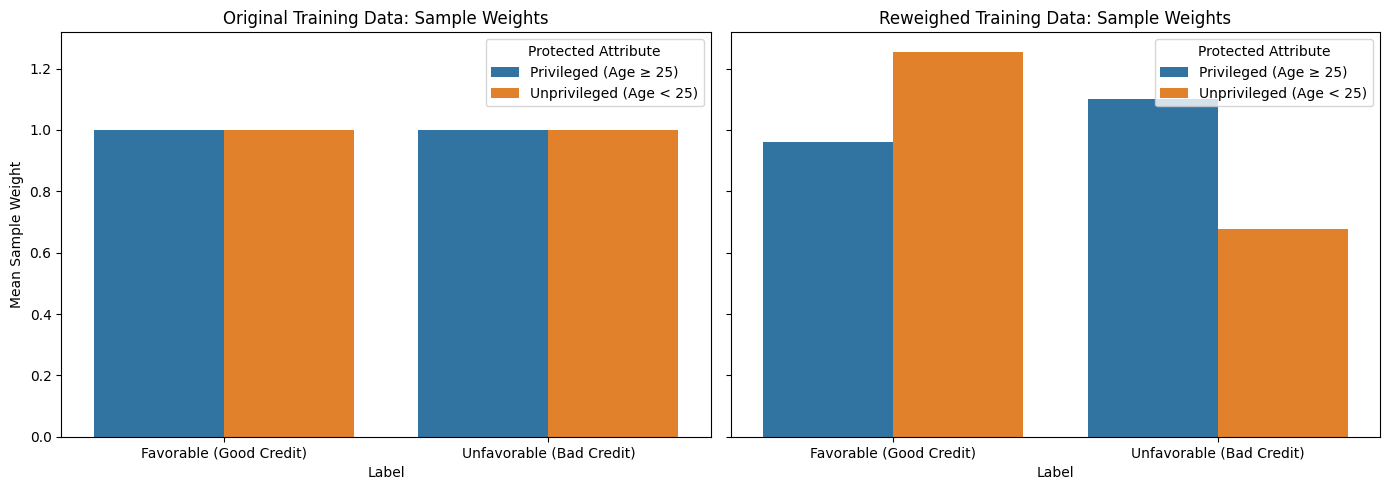

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Extract protected attribute, label, and weights from a BinaryLabelDataset
def extract_weights(dataset):
    # If instance_weights do not exist (e.g., original data), assume weight = 1 for all
    weights = dataset.instance_weights if hasattr(dataset, 'instance_weights') else np.ones(len(dataset.labels))
    df = pd.DataFrame({
        'protected': dataset.protected_attributes[:, 0],  # e.g., age binary attribute
        'label': dataset.labels[:, 0],                    # class label
        'weight': weights
    })
    return df

# Extract data for original and reweighted datasets
df_orig = extract_weights(dataset_orig_train)
df_rw = extract_weights(dataset_transf_train)

protected_mapping = {
    0: "Unprivileged (Age < 25)",
    1: "Privileged (Age ≥ 25)"
}
label_mapping = {
    2: "Unfavorable (Bad Credit)",
    1: "Favorable (Good Credit)"
}

df_orig['protected_str'] = df_orig['protected'].map(protected_mapping)
df_orig['label_str'] = df_orig['label'].map(label_mapping)

df_rw['protected_str'] = df_rw['protected'].map(protected_mapping)
df_rw['label_str'] = df_rw['label'].map(label_mapping)

# Compute mean weights per (protected_str, label_str) group
grouped_orig = df_orig.groupby(['protected_str', 'label_str'])['weight'].mean().reset_index()
grouped_rw = df_rw.groupby(['protected_str', 'label_str'])['weight'].mean().reset_index()

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

sns.barplot(data=grouped_orig, x='label_str', y='weight', hue='protected_str', ax=axes[0])
axes[0].set_title('Original Training Data: Sample Weights')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Mean Sample Weight')
axes[0].legend(title='Protected Attribute')

sns.barplot(data=grouped_rw, x='label_str', y='weight', hue='protected_str', ax=axes[1])
axes[1].set_title('Reweighed Training Data: Sample Weights')
axes[1].set_xlabel('Label')
axes[1].legend(title='Protected Attribute')

plt.tight_layout()
plt.show()

In [8]:
print("Original grouped weights:")
print(grouped_orig)

print("\nReweighted grouped weights:")
print(grouped_rw)

Original grouped weights:
             protected_str                 label_str  weight
0    Privileged (Age ≥ 25)   Favorable (Good Credit)     1.0
1    Privileged (Age ≥ 25)  Unfavorable (Bad Credit)     1.0
2  Unprivileged (Age < 25)   Favorable (Good Credit)     1.0
3  Unprivileged (Age < 25)  Unfavorable (Bad Credit)     1.0

Reweighted grouped weights:
             protected_str                 label_str    weight
0    Privileged (Age ≥ 25)   Favorable (Good Credit)  0.962295
1    Privileged (Age ≥ 25)  Unfavorable (Bad Credit)  1.100625
2  Unprivileged (Age < 25)   Favorable (Good Credit)  1.255556
3  Unprivileged (Age < 25)  Unfavorable (Bad Credit)  0.678000


## Step 6: Train 2 models with original and transformed datasets

In [9]:
from lightgbm import LGBMClassifier
from aif360.metrics import ClassificationMetric
from aif360.datasets import BinaryLabelDataset
from sklearn.metrics import accuracy_score, roc_auc_score
from copy import deepcopy

In [10]:
# Helper function to extract features (X), labels (y), and sample weights (w) from a BinaryLabelDataset
def dataset_to_X_y_w(dataset: BinaryLabelDataset):
    X = dataset.features                    # feature matrix (numpy array)
    y = dataset.labels.ravel()              # labels as 1D array
    # if instance weights exist (e.g., after reweighing), use them; otherwise assume all weights = 1
    w = dataset.instance_weights if hasattr(dataset, 'instance_weights') else np.ones(len(y))
    return X, y, w

In [11]:
# Convert to X,y,w for original training data
X_train_orig, y_train_orig, w_train_orig = dataset_to_X_y_w(dataset_orig_train)

# Convert to X,y,w for reweighed training data
X_train_rw, y_train_rw, w_train_rw = dataset_to_X_y_w(dataset_transf_train)

# Convert to X,y,w for test data
X_test, y_test, w_test = dataset_to_X_y_w(dataset_orig_test)

In [12]:
# Train model on original training data
model_orig = LGBMClassifier(random_state=42)
model_orig.fit(X_train_orig, y_train_orig, sample_weight=w_train_orig)
y_pred_orig = model_orig.predict(X_test)
y_prob_orig = model_orig.predict_proba(X_test)[:, 1]

# Train model on reweighed training data
model_rw = LGBMClassifier(random_state=42)
model_rw.fit(X_train_rw, y_train_rw, sample_weight=w_train_rw)
y_pred_rw = model_rw.predict(X_test)
y_prob_rw = model_rw.predict_proba(X_test)[:, 1]

[LightGBM] [Info] Number of positive: 210, number of negative: 490
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 365
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.300000 -> initscore=-0.847298
[LightGBM] [Info] Start training from score -0.847298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/opt/anaconda3/envs/ccai9012/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/ccai9012/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/ccai9012/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/ccai9012/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## Evaluate model performances on test set

In [13]:
# Prepare predicted label datasets for fairness metric calculation
dataset_orig_test_pred_orig = deepcopy(dataset_orig_test)
dataset_orig_test_pred_orig.labels = y_pred_orig.reshape(-1, 1)

dataset_orig_test_pred_rw = deepcopy(dataset_orig_test)
dataset_orig_test_pred_rw.labels = y_pred_rw.reshape(-1, 1)

In [14]:
# Calculate accuracy and AUC
acc_orig = accuracy_score(y_test, y_pred_orig)
auc_orig = roc_auc_score(y_test, y_prob_orig)

acc_rw = accuracy_score(y_test, y_pred_rw)
auc_rw = roc_auc_score(y_test, y_prob_rw)

# Calculate fairness metrics
metric_orig = ClassificationMetric(dataset_orig_test, dataset_orig_test_pred_orig,
                                   unprivileged_groups=unprivileged_groups,
                                   privileged_groups=privileged_groups)
metric_rw = ClassificationMetric(dataset_orig_test, dataset_orig_test_pred_rw,
                                unprivileged_groups=unprivileged_groups,
                                privileged_groups=privileged_groups)

print("Original Data Model Performance:")
print(f"  Accuracy: {acc_orig:.4f}")
print(f"  AUC: {auc_orig:.4f}")
print(f"  Statistical Parity Difference: {metric_orig.statistical_parity_difference():.4f}")
print(f"  Equal Opportunity Difference: {metric_orig.equal_opportunity_difference():.4f}")

print("\nReweighed Data Model Performance:")
print(f"  Accuracy: {acc_rw:.4f}")
print(f"  AUC: {auc_rw:.4f}")
print(f"  Statistical Parity Difference: {metric_rw.statistical_parity_difference():.4f}")
print(f"  Equal Opportunity Difference: {metric_rw.equal_opportunity_difference():.4f}")

Original Data Model Performance:
  Accuracy: 0.7833
  AUC: 0.7981
  Statistical Parity Difference: -0.1427
  Equal Opportunity Difference: -0.2173

Reweighed Data Model Performance:
  Accuracy: 0.7867
  AUC: 0.8000
  Statistical Parity Difference: -0.0354
  Equal Opportunity Difference: -0.0973


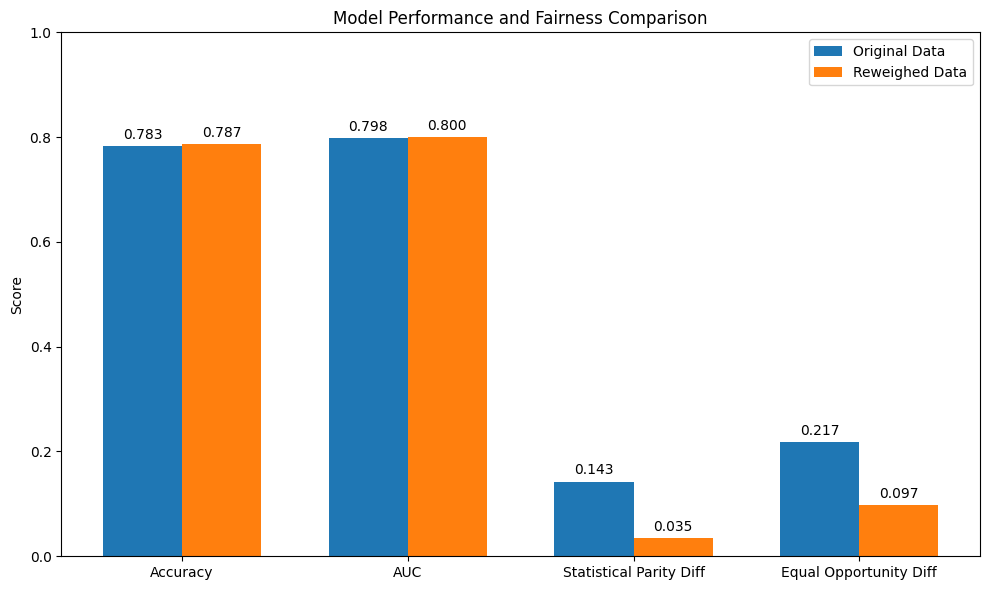

In [15]:
# Annotate bars with values
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')


# Prepare metric names and corresponding values from your variables
metrics = ['Accuracy', 'AUC', 'Statistical Parity Diff', 'Equal Opportunity Diff']

orig_scores = [
    acc_orig,
    auc_orig,
    abs(metric_orig.statistical_parity_difference()),
    abs(metric_orig.equal_opportunity_difference())
]

rw_scores = [
    acc_rw,
    auc_rw,
    abs(metric_rw.statistical_parity_difference()),
    abs(metric_rw.equal_opportunity_difference())
]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars for original and reweighed models side-by-side
rects1 = ax.bar(x - width/2, orig_scores, width, label='Original Data')
rects2 = ax.bar(x + width/2, rw_scores, width, label='Reweighed Data')

# Labels and title
ax.set_ylabel('Score')
ax.set_title('Model Performance and Fairness Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

autolabel(rects1)
autolabel(rects2)

# Set y-limit to [0, 1] for clarity
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()